In [4]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import HTML,SVG
from pydae.svg_tools import svg
%config InlineBackend.figure_formats = ['svg']

In [5]:
import ev1

ModuleNotFoundError: No module named 'ev1_cffi'

In [3]:
ev = ev1.model()
ev.ini({'tau_r_ref':0,'K_sign':0.1,'C_rr':0.01},1)
ev.report_x()
ev.report_y()
#m.report_u()

ev.report_params()
ev.report_z()
ev.save_xy_0('xy_0.json')

NameError: name 'ev1' is not defined

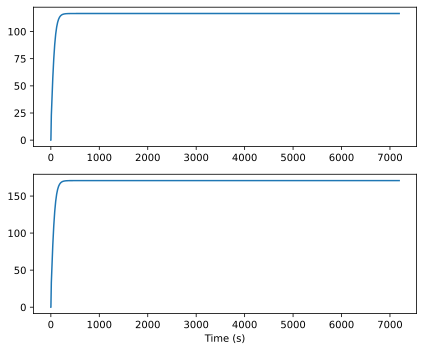

In [8]:
ev = ev1.model()
ev.Dt = 1.0
ev.ini({'tau_r_ref':0,'K_sign':1.0,'C_rr':0.03,'R_b':0.01,'C_b':1e6,'soc_ref':0.95},'xy_0.json')
ev.run( 1.0,{'tau_r_ref':0.0, 'K_w':0.1})
ev.run( 2.0,{'tau_r_ref':100, 'K_w':0.1})
ev.run( 4.0,{'tau_r_ref':100, 'K_w':0.2})
ev.run( 5.0,{'tau_r_ref':100, 'K_w':0.4})
ev.run(2*60*60,{'tau_r_ref':150, 'K_w':0.6})

ev.post();

fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(6, 5), dpi=100)

axes[0].plot(ev.Time, ev.get_values('nu_kmh'), label=f'\nu')
axes[1].plot(ev.Time, ev.get_values('omega_r'), label=f'\nu')

#axes.plot(m.get_values('nu'), m.get_values('snu'), label=f'\nu')

axes[1].set_xlabel('Time (s)')
fig.tight_layout()

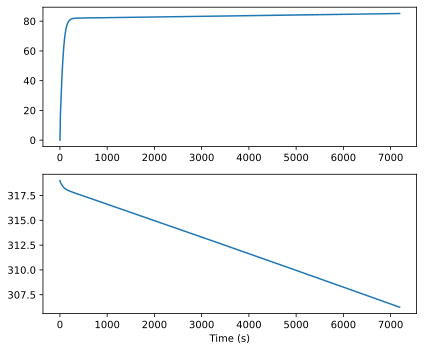

In [9]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(6, 5), dpi=100)

axes[0].plot(ev.Time, ev.get_values('i_b'), label=f'\nu')
axes[1].plot(ev.Time, ev.get_values('v_b'), label=f'\nu')

#axes.plot(m.get_values('nu'), m.get_values('snu'), label=f'\nu')

axes[1].set_xlabel('Time (s)')
fig.tight_layout()

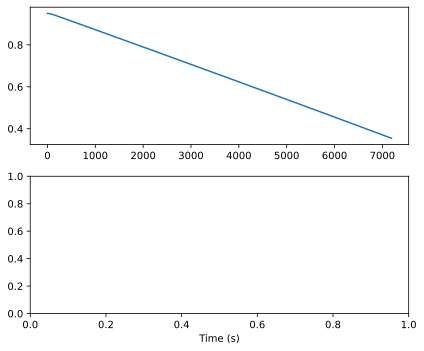

In [10]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(6, 5), dpi=100)

axes[0].plot(ev.Time, ev.get_values('soc'), label=f'\nu')

#axes.plot(m.get_values('nu'), m.get_values('snu'), label=f'\nu')

axes[1].set_xlabel('Time (s)')
fig.tight_layout()

In [13]:
import pandas as pd
df = pd.read_excel('WLTP-DHC-12-07e.xls', sheet_name='WLTC_class_3', usecols=[2,3,4,5,6], skiprows=[0,1,2,3,4,6])
T_cycle = df['Total elapsed time'].values
Nu_ref  = df['WLTC class 3, version 5, vehicle speed'].values/3.6 # m/s
dNu_ref = df['WLTC class 3, version 5, acceleration'].values      # m/s**2

In [220]:
dt_mid = 0.5
times = np.arange(0,1800,dt_mid)
ev = ev1.model()

ev.Dt = 0.1
ev.ini({'tau_r_ref':0,'K_sign':1.0,'C_rr':0.03,'R_b':0.01,'C_b':1e6,'soc_ref':0.95},'xy_0.json')
M,K_w,R_w = ev.get_mvalue(['M','K_w','R_w'])
Rho,S_f,C_x,C_rr,G = ev.get_mvalue(['Rho','S_f','C_x','C_rr','G'])
xi_nu = 0.0
F_t_ref = []


for t in times:
    
    nu_ref = np.interp(t,T_cycle,Nu_ref)
    dnu_ref_1 = np.interp(t,T_cycle,dNu_ref)
    dnu_ref_2 = np.interp(t+dt_mid,T_cycle,dNu_ref)
    der = 0.5
    dnu_ref = dnu_ref_1*(1.0-der) + dnu_ref_2*der
    
    nu = ev.get_value('nu') # m/s
    f_d_est = 0.5*Rho*S_f*C_x*np.abs(nu_ref)*nu_ref
    f_r_est = 0.0
    if nu_ref>1:
        f_r_est = C_rr*G*M

    
    f_t_ref = dnu_ref*M + f_d_est + f_r_est
    F_t_ref += [f_t_ref]
    
    epsilon_nu = nu_ref - nu
    tau_r_ref = f_t_ref*(K_w * R_w) +100.0*xi_nu + 300*epsilon_nu 
    xi_nu += dt_mid*epsilon_nu
    
    ev.run( t,{'tau_r_ref':tau_r_ref})
    
ev.post();

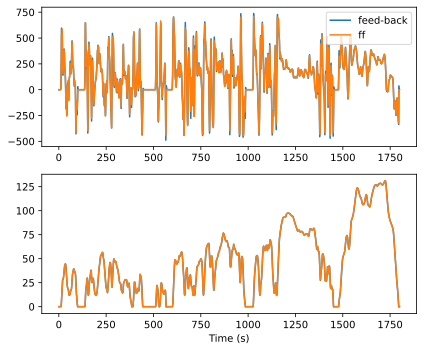

In [221]:
fig, axes = plt.subplots(nrows=2,ncols=1, figsize=(6, 5), dpi=100)

axes[0].plot(ev.Time, ev.get_values('tau_r'), label=f'feed-back')
axes[0].plot(times, np.array(F_t_ref)*(K_w * R_w), label=f'ff')

axes[1].plot(T_cycle,Nu_ref*3.6, label=f'\nu')
axes[1].plot(ev.Time, ev.get_values('nu_kmh'), label=f'\nu')


#axes.plot(m.get_values('nu'), m.get_values('snu'), label=f'\nu')
axes[0].legend()
axes[1].set_xlabel('Time (s)')
fig.tight_layout()

In [101]:
f_d_est

-1333.5000790716424